In [1]:
import os
import sys

# path variables
root = os.path.join(os.getenv("REPO_ROOT"), "src")
%cd $root
sys.path.insert(0, root)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# plotting
%matplotlib inline
sns.set_style("whitegrid")

from etl import get_latest_concatenated

/Users/stevenkim/src/github/nypdcd/src


# Ingestion

In [2]:
df = get_latest_concatenated()
display(df.head())
print(df.shape)
print(df.columns)

/Users/stevenkim/src/github/nypdcd/.venv/lib/python3.8/site-packages/pandas/core/reshape/concat.py:271: DtypeWarning: Columns (18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  op = _Concatenator(


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
CMPLNT_NUM,,,,,,,,,,,,,,,,,,,,,
100000065,100000065,09/22/2018,23:35:00,NaN,NaN,14.0,09/23/2018,110,GRAND LARCENY OF MOTOR VEHICLE,441.0,...,NaN,NaN,40.750327,-73.991112,"(40.750326623, -73.991112045)",PATROL BORO MAN SOUTH,NaN,45-64,BLACK,M
100000228,100000228,02/08/2012,18:00:00,02/08/2012,19:00:00,60.0,02/09/2012,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,M,NaN,40.576238,-73.959504,"(40.576237762, -73.959504022)",PATROL BORO BKLYN SOUTH,NaN,45-64,WHITE,F
100000272,100000272,01/31/2016,00:40:00,01/31/2016,00:50:00,46.0,01/31/2016,236,DANGEROUS WEAPONS,782.0,...,M,NaN,40.858249,-73.902349,"(40.858249408, -73.902348526)",PATROL BORO BRONX,NaN,UNKNOWN,UNKNOWN,E
100000431,100000431,05/10/2018,15:00:00,05/14/2018,15:00:00,17.0,05/14/2018,351,CRIMINAL MISCHIEF & RELATED OF,258.0,...,U,NaN,40.747017,-73.977189,"(40.747017286, -73.977188972)",PATROL BORO MAN SOUTH,NaN,UNKNOWN,UNKNOWN,E
100000480,100000480,01/26/2010,17:00:00,NaN,NaN,41.0,01/27/2010,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,M,NaN,40.804013,-73.878332,"(40.804012949, -73.878331833)",PATROL BORO BRONX,NaN,18-24,WHITE HISPANIC,M


(6626501, 35)
Index(['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'ADDR_PCT_CD', 'RPT_DT', 'KY_CD', 'OFNS_DESC', 'PD_CD',
       'PD_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM',
       'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC', 'JURIS_DESC', 'JURISDICTION_CODE',
       'PARKS_NM', 'HADEVELOPT', 'HOUSING_PSA', 'X_COORD_CD', 'Y_COORD_CD',
       'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT',
       'Latitude', 'Longitude', 'Lat_Lon', 'PATROL_BORO', 'STATION_NAME',
       'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX'],
      dtype='object')


# Sanity checks

## Internal descriptions

In [3]:
df.PD_DESC.value_counts().head(10)

ASSAULT 3                         574088
HARASSMENT,SUBD 3,4,5             526976
AGGRAVATED HARASSMENT 2           347169
LARCENY,PETIT FROM STORE-SHOPL    310618
HARASSMENT,SUBD 1,CIVILIAN        298556
LARCENY,PETIT FROM BUILDING,UN    283371
MISCHIEF, CRIMINAL 4, OF MOTOR    235093
LARCENY,PETIT FROM AUTO           217112
ASSAULT 2,1,UNCLASSIFIED          204766
MARIJUANA, POSSESSION 4 & 5       197741
Name: PD_DESC, dtype: int64

## Transit crimes

In [4]:
df.TRANSIT_DISTRICT.value_counts()  # this is something related to NYPD transit enforcement

4.0     25661
2.0     17869
3.0     14467
1.0     13995
20.0    13159
33.0    13098
12.0    11067
11.0    10034
32.0     9987
30.0     9464
34.0     6500
23.0     2467
Name: TRANSIT_DISTRICT, dtype: int64

In [5]:
df.TRANSIT_DISTRICT.count()

147768

In [6]:
df.TRANSIT_DISTRICT.count() / df.shape[0]

0.02229955145256901

In [7]:
df.STATION_NAME.value_counts()

125 STREET                        7577
14 STREET                         4178
34 ST.-PENN STATION               3520
42 ST.-PORT AUTHORITY BUS TERM    3447
116 STREET                        3254
                                  ... 
DISTRICT 30 OFFICE                  16
DISTRICT 34 OFFICE                  12
WEST 34 STREET/HUDSON YARDS          9
DISTRICT 23 OFFICE                   6
OFF-SYSTEM                           4
Name: STATION_NAME, Length: 372, dtype: int64

In [8]:
df.STATION_NAME.count()

147768

In [9]:
df.STATION_NAME.count() / df.shape[0]

0.02229955145256901

In [10]:
(df.STATION_NAME.isnull() == df.TRANSIT_DISTRICT.isnull()).all()

True

## Jurisdictions

In [11]:
df.JURIS_DESC.value_counts()

N.Y. POLICE DEPT                       5886216
N.Y. HOUSING POLICE                     507559
N.Y. TRANSIT POLICE                     148115
PORT AUTHORITY                           31755
OTHER                                    20572
POLICE DEPT NYC                           8955
DEPT OF CORRECTIONS                       8925
TRI-BORO BRDG TUNNL                       5371
HEALTH & HOSP CORP                        3344
N.Y. STATE POLICE                         1675
METRO NORTH                                743
NYC PARKS                                  637
LONG ISLAND RAILRD                         525
FIRE DEPT (FIRE MARSHAL)                   477
N.Y. STATE PARKS                           421
STATN IS RAPID TRANS                       406
U.S. PARK POLICE                           240
NEW YORK CITY SHERIFF OFFICE               231
AMTRACK                                    181
NYS DEPT TAX AND FINANCE                    92
SEA GATE POLICE DEPT                        30
CONRAIL      

In [12]:
df.loc[(df.JURIS_DESC == "N.Y. TRANSIT POLICE") & df.TRANSIT_DISTRICT.isnull()]

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
CMPLNT_NUM,,,,,,,,,,,,,,,,,,,,,
100026305,100026305,09/26/2007,20:30:00,NaN,NaN,60.0,09/26/2007,118,DANGEROUS WEAPONS,793.0,...,NaN,NaN,40.576995,-73.981524,"(40.57699549, -73.981523609)",PATROL BORO BKLYN SOUTH,NaN,NaN,UNKNOWN,E
100827796,100827796,08/10/2015,02:10:00,08/10/2015,02:10:00,73.0,08/10/2015,109,GRAND LARCENY,415.0,...,U,NaN,40.682666,-73.910026,"(40.682666375, -73.910025795)",PATROL BORO BKLYN NORTH,NaN,25-44,WHITE,M
102391253,102391253,12/01/2010,20:00:00,12/02/2010,22:15:00,32.0,12/03/2010,121,CRIMINAL MISCHIEF & RELATED OF,268.0,...,NaN,NaN,40.823575,-73.937675,"(40.82357528, -73.937674609)",PATROL BORO MAN NORTH,NaN,NaN,UNKNOWN,E
103114647,103114647,03/28/2006,14:39:00,03/28/2006,14:50:00,25.0,03/28/2006,351,CRIMINAL MISCHIEF & RELATED OF,258.0,...,NaN,NaN,40.804384,-73.937422,"(40.804384046, -73.937421669)",PATROL BORO MAN NORTH,NaN,NaN,UNKNOWN,D
107514212,107514212,05/30/2006,08:20:00,NaN,NaN,14.0,05/30/2006,341,PETIT LARCENY,339.0,...,NaN,NaN,40.750999,-73.990625,"(40.750999048, -73.990624712)",PATROL BORO MAN SOUTH,NaN,18-24,WHITE,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994294993,994294993,01/24/2006,17:12:00,01/24/2006,17:12:00,19.0,01/24/2006,113,FORGERY,729.0,...,NaN,NaN,40.773650,-73.959857,"(40.773650293, -73.959856952)",PATROL BORO MAN NORTH,NaN,NaN,UNKNOWN,E
994401226,994401226,01/06/2015,15:00:00,01/06/2015,17:11:00,28.0,01/06/2015,106,FELONY ASSAULT,109.0,...,M,NaN,40.807781,-73.945485,"(40.807780622, -73.945484727)",PATROL BORO MAN NORTH,NaN,<18,BLACK,F
995608998,995608998,03/22/2011,16:10:00,03/22/2011,16:25:00,40.0,03/22/2011,359,OFFENSES AGAINST PUBLIC ADMINI,750.0,...,NaN,NaN,40.810396,-73.925311,"(40.810396019, -73.925310745)",PATROL BORO BRONX,NaN,NaN,UNKNOWN,E


In [13]:
df.loc[~(df.JURIS_DESC == "N.Y. TRANSIT POLICE") & ~df.STATION_NAME.isnull()]

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
CMPLNT_NUM,,,,,,,,,,,,,,,,,,,,,
100193263,100193263,08/24/2012,14:00:00,08/24/2012,16:00:00,42.0,08/28/2012,109,GRAND LARCENY,401.0,...,NaN,12.0,40.830084,-73.893425,"(40.830083536, -73.893424754)",PATROL BORO BRONX,FREEMAN STREET,18-24,BLACK,F
100977345,100977345,05/06/2008,09:00:00,05/06/2008,09:00:00,10.0,05/06/2008,236,DANGEROUS WEAPONS,782.0,...,NaN,2.0,40.742858,-74.002123,"(40.742858483, -74.002123407)",PATROL BORO MAN SOUTH,14 STREET,NaN,UNKNOWN,E
101815739,101815739,05/27/2007,00:55:00,05/27/2007,01:00:00,60.0,05/27/2007,106,FELONY ASSAULT,109.0,...,NaN,34.0,40.576157,-73.975984,"(40.5761573, -73.9759838)",PATROL BORO BKLYN SOUTH,STILLWELL AVENUE-CONEY ISLAND,45-64,BLACK,M
104011480,104011480,07/28/2012,22:00:00,07/28/2012,22:15:00,13.0,07/28/2012,109,GRAND LARCENY,419.0,...,U,4.0,40.736698,-73.983316,"(40.73669807, -73.983316026)",PATROL BORO MAN SOUTH,23 STREET,25-44,ASIAN / PACIFIC ISLANDER,F
106559377,106559377,07/17/2008,16:00:00,07/17/2008,17:45:00,26.0,07/17/2008,109,GRAND LARCENY,439.0,...,NaN,3.0,40.814850,-73.956682,"(40.814850289, -73.956681848)",PATROL BORO MAN NORTH,116 ST.-COLUMBIA UNIVERSITY,25-44,WHITE,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996397846,996397846,09/20/2016,19:30:00,09/21/2016,08:00:00,114.0,09/21/2016,109,GRAND LARCENY,406.0,...,U,20.0,40.770781,-73.917261,"(40.770781285, -73.917260908)",PATROL BORO QUEENS NORTH,ASTORIA BLVD.,25-44,WHITE,F
997720742,997720742,01/23/2010,13:30:00,01/23/2010,13:50:00,13.0,01/28/2010,109,GRAND LARCENY,419.0,...,U,4.0,40.736698,-73.983316,"(40.73669807, -73.983316026)",PATROL BORO MAN SOUTH,14 ST.-UNION SQUARE,45-64,ASIAN / PACIFIC ISLANDER,F
997851809,997851809,10/31/2011,04:50:00,NaN,NaN,1.0,11/01/2011,109,GRAND LARCENY,419.0,...,NaN,2.0,40.720255,-74.007090,"(40.720255223, -74.00709028)",PATROL BORO MAN SOUTH,CHAMBERS ST.-WORLD TRADE CENTE,18-24,WHITE HISPANIC,F


## What happens in train stations?

In [14]:
df.loc[:, "OFNS_DESC"].value_counts() / df.shape[0]

PETIT LARCENY                      1.655385e-01
HARRASSMENT 2                      1.245792e-01
ASSAULT 3 & RELATED OFFENSES       1.041296e-01
CRIMINAL MISCHIEF & RELATED OF     1.001704e-01
GRAND LARCENY                      8.659170e-02
                                       ...     
ABORTION                           1.056364e-06
UNDER THE INFLUENCE OF DRUGS       4.527276e-07
FELONY SEX CRIMES                  4.527276e-07
OFFENSES AGAINST MARRIAGE UNCL     4.527276e-07
KIDNAPPING AND RELATED OFFENSES    3.018184e-07
Name: OFNS_DESC, Length: 71, dtype: float64

In [15]:
flt = ~df.STATION_NAME.isnull()
df.loc[flt, "OFNS_DESC"].value_counts() / flt.sum()

GRAND LARCENY                       0.137648
CRIMINAL MISCHIEF & RELATED OF      0.101395
PETIT LARCENY                       0.089248
DANGEROUS WEAPONS                   0.082251
FORGERY                             0.081445
ASSAULT 3 & RELATED OFFENSES        0.081242
ROBBERY                             0.059032
HARRASSMENT 2                       0.058233
OFFENSES AGAINST PUBLIC ADMINI      0.055553
DANGEROUS DRUGS                     0.046208
SEX CRIMES                          0.043446
THEFT OF SERVICES                   0.027970
MISCELLANEOUS PENAL LAW             0.025032
FELONY ASSAULT                      0.021439
POSSESSION OF STOLEN PROPERTY       0.016966
FRAUDS                              0.014394
OFF. AGNST PUB ORD SENSBLTY &       0.013095
OFFENSES AGAINST THE PERSON         0.007322
OFFENSES INVOLVING FRAUD            0.004609
OTHER OFFENSES RELATED TO THEF      0.003269
BURGLAR'S TOOLS                     0.002829
CRIMINAL TRESPASS                   0.001665
ADMINISTRA

## Breakdown by race

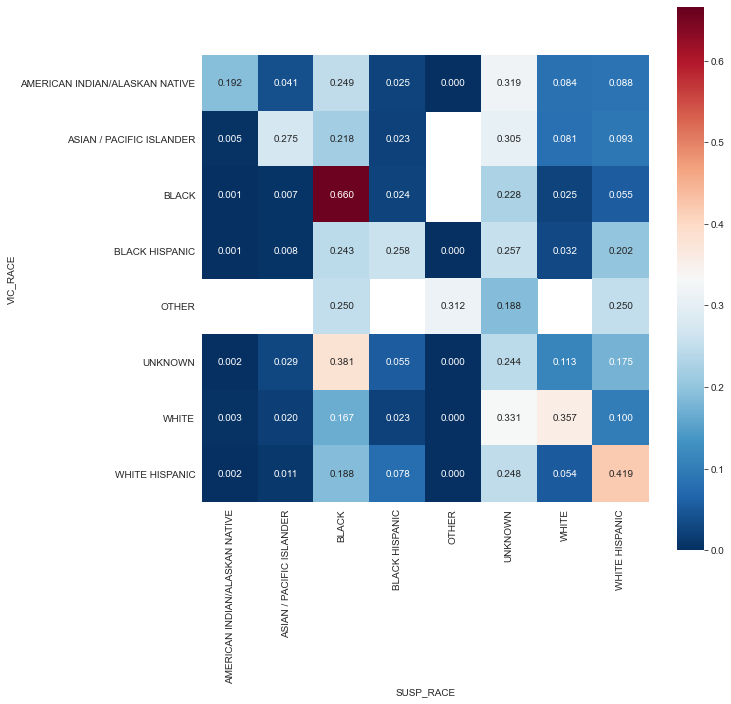

In [16]:
cross_table = (
    df
    .groupby(['SUSP_RACE', 'VIC_RACE'])
    ['OFNS_DESC']
    .count()
    .unstack(level=0)
)
cross_table = cross_table.divide(cross_table.sum(axis=1), axis=0)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(
    cross_table, 
    cmap='RdBu_r', 
    ax=ax,
    square=True,
    vmin=0, 
    vmax=0.666,
    annot=True,
    fmt='.3f',
)

In [17]:
anti_asian = (
    df
    .groupby((df.VIC_RACE == "ASIAN / PACIFIC ISLANDER"))
    ["OFNS_DESC"]
    .value_counts()
    .unstack(level=0)
)
anti_asian /= anti_asian.sum(axis=0)
anti_asian.columns = anti_asian.columns.map({True: "AAPI", False: "Other"})
anti_asian = anti_asian.assign(
    abs_gap=anti_asian['AAPI'] - anti_asian['Other'],
    rel_gap=anti_asian['AAPI'] / anti_asian['Other'],
)

anti_asian.sort_values('abs_gap', ascending=False).head(10)

VIC_RACE,Other,AAPI,abs_gap,rel_gap
OFNS_DESC,,,,
GRAND LARCENY,0.083071,0.150514,0.067444,1.811887
ROBBERY,0.034785,0.071684,0.036899,2.060764
BURGLARY,0.033881,0.054070,0.020188,1.595854
ASSAULT 3 & RELATED OFFENSES,0.103598,0.118418,0.014819,1.143048
GRAND LARCENY OF MOTOR VEHICLE,0.017800,0.027080,0.009280,1.521356
HARRASSMENT 2,0.124565,0.131161,0.006596,1.052949
OTHER OFFENSES RELATED TO THEF,0.001950,0.006615,0.004666,3.393163
THEFT-FRAUD,0.010705,0.014837,0.004132,1.386022
VEHICLE AND TRAFFIC LAWS,0.012004,0.014206,0.002202,1.183419


# Notes

* Check in on this again after Q2 data released?
* There is OK time coverage (history), space coverage (all of NY) and modest feature set (attributes of complaints).